In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

C:\Users\danie\AppData\Local\Temp\ipykernel_30960\873636676.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine,reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
with engine.connect() as conn:
    result = conn.execute(text('SELECT max(date) FROM Measurement'))
    for record in result:
        last_date=record[0]
        print(last_date)

2017-08-23


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date_2 = datetime.strptime(last_date, '%Y-%m-%d').date()
print(last_date_2)

2017-08-23


In [12]:
# Calculate the date one year from the last date in data set.
previous_date=last_date_2-timedelta(days=365)
print(previous_date)

2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-24").\
    filter(Measurement.date <= "2017-08-23").all()
precipitation_data

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06', 0.0),
 ('2016-10-07'

In [14]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df=pd.DataFrame(precipitation_data).rename(columns={'date': 'Date', 'prcp': 'Precipitation'})
precipitation_df

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01
...,...,...
2218,2017-08-19,0.09
2219,2017-08-20,NaN
2220,2017-08-21,0.56
2221,2017-08-22,0.50


In [35]:
# Sort the dataframe by date
precipitation_df=precipitation_df.sort_values('Date',ascending=True).dropna()
precipitation_df

,Date,Precipitation
0,2016-08-24,0.08
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15
1875,2016-08-24,1.45
...,...,...
358,2017-08-22,0.00
1005,2017-08-23,0.00
1523,2017-08-23,0.08
359,2017-08-23,0.00


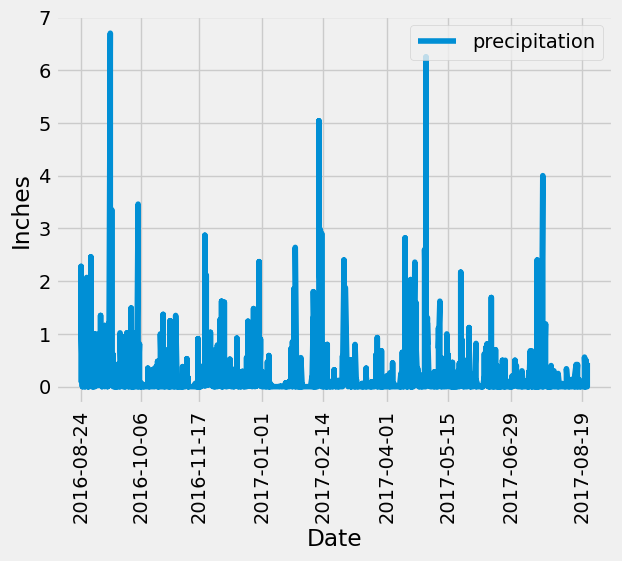

In [38]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(precipitation_df['Date'],precipitation_df['Precipitation'])
ticks = plt.xticks(precipitation_df['Date'][::250],rotation=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(['precipitation'],loc='upper right')
plt.show()

In [42]:
# Use Pandas to calculate the summary statistics for the precipitation data
sum_stats_df=pd.DataFrame(precipitation_df['Precipitation'].describe())
sum_stats_df

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [44]:
# Design a query to calculate the total number of stations in the dataset
station_count=session.query(Station.station).count()
station_count

9

In [45]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_data=session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [46]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_analysis=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station==station_data[0][0]).all()
temperature_analysis

[(54.0, 85.0, 71.66378066378067)]

In [47]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs).filter(Measurement.date >= "2016-08-24").\
    filter(Measurement.date <= "2017-08-23").\
    filter(Measurement.station==station_data[0][0]).all()
temp_data

temp_data_df=pd.DataFrame(temp_data)
temp_data_df

,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0
...,...
346,77.0
347,77.0
348,76.0
349,76.0


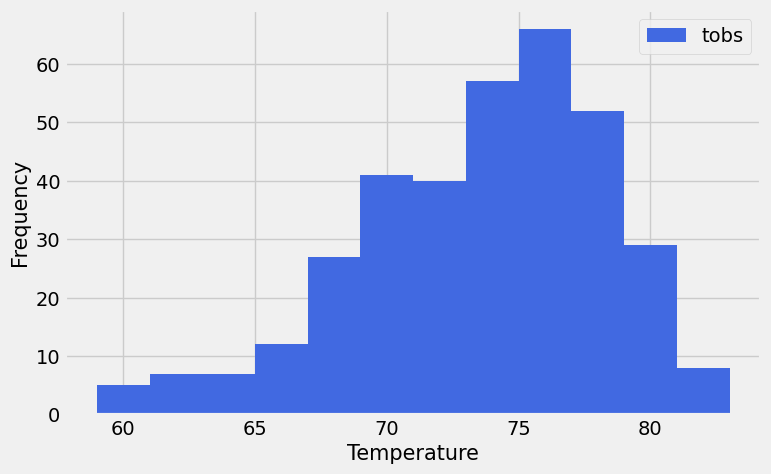

In [50]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
hist = temp_data_df['tobs'].hist(bins=12,figsize=(8,5), color='royalblue', zorder=2)
hist.set_xlabel("Temperature", size=15)
hist.set_ylabel("Frequency", size=15)
hist.legend(['tobs'],loc='upper right')
plt.show()

# Close Session

In [51]:
# Close Session
session.close()